In [36]:
#Load the model
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from PIL import Image
from ai_edge_litert.interpreter import Interpreter

In [37]:
MODELS_DIR = '../models'
MODEL_NAME='final_classification_model.keras'
TFLITE_MODEL_NAME='classification_model.tflite'
#file with classes
CLASSES_JSON = 'class_indices.json'
TARGET_SIZE = (320, 320)

## |Saving the model as a TFLite Model

In [38]:
#Load model
model_file_path=f'{MODELS_DIR}/{MODEL_NAME}'
model = keras.models.load_model(model_file_path)
print("Model loaded...")

Model loaded...


In [39]:
#saving the model as a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model) 
tflite_model= converter.convert()

tflite_model_path=f'{MODELS_DIR}/{TFLITE_MODEL_NAME}'
with open(tflite_model_path,'wb') as f_out:
    f_out.write(tflite_model)
print (f"Tensor flow lite model saved as: {tflite_model_path}")

INFO:tensorflow:Assets written to: /tmp/tmp9at8vmv4/assets


INFO:tensorflow:Assets written to: /tmp/tmp9at8vmv4/assets


Saved artifact at '/tmp/tmp9at8vmv4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 320, 320, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 128), dtype=tf.float32, name=None)
Captures:
  139995876342240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139995876342768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139995876343120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139995876340304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139995876340128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139996743726528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139995876263184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139995876264944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139995876265472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139995876265648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13999674326

W0000 00:00:1736180118.410339   20776 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1736180118.410386   20776 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-06 11:15:18.410565: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp9at8vmv4
2025-01-06 11:15:18.420555: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-06 11:15:18.420578: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp9at8vmv4
2025-01-06 11:15:18.525673: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-06 11:15:19.114378: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp9at8vmv4
2025-01-06 11:15:19.266909: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 856348 microseconds.


In [5]:
#load classes from json file
classes_json_path=f'{MODELS_DIR}/{CLASSES_JSON}'
class_indices={}
with open(classes_json_path, 'r') as json_file:
    class_indices = json.load(json_file)
print("Class indices loaded...")

Class indices loaded...


## Running predictions for items that the model classifies well

In [19]:
def show_image(image_path):
    img = Image.open(image_path)
    
    # Resize the image
    img_resized = img.resize(TARGET_SIZE, Image.NEAREST)
    
    plt.imshow(img_resized)
    plt.axis('off')  # Hides the axes
    plt.show()

In [6]:
def prepare_input(image_path):
    with Image.open(image_path, 'r') as img:
        img = img.resize((TARGET_SIZE), Image.NEAREST)
    x = np.array(img, dtype='float32')
    X = np.array([x])
    return preprocess_input(X)

In [7]:
def preprocess_input(x):
        x /= 127.5
        x -= 1.0
        return x

In [8]:
def predict(interpreter, X):
    input_index = interpreter.get_input_details()[0]['index']
    output_index =interpreter.get_output_details()[0]['index']
    interpreter.set_tensor(input_index, X)
    interpreter.invoke()
    return interpreter.get_tensor(output_index)

In [9]:
def decode_predictions(preds, class_indices):
    predictions=preds[0]
    #order in descendent order
    sorted_indices = np.argsort(predictions)[::-1]  

    top_n = 5
    top_classes = []
    top_scores = []

    index_to_class = {index: label for label, index in class_indices.items()}

    for i in range(top_n):
        index = sorted_indices[i]
        class_label = index_to_class[index] 
        score = predictions[index]
        top_classes.append((class_label, score))

    return top_classes
    

## Using LiteRT for inference

In [22]:
#create a LiteRT Interpreter
interpreter = Interpreter(tflite_model_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [23]:
#get the first image for predictions

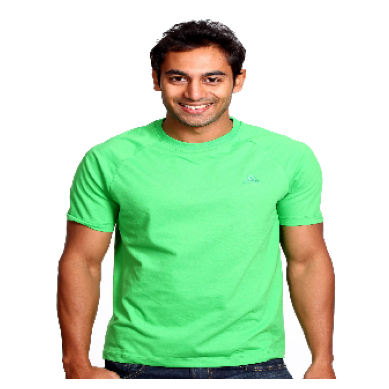

In [24]:
image_path='../dataset/test-images/2241.jpg'
show_image(image_path)

In [25]:
preds = predict(interpreter, prepare_input(image_path))
top_predictions = decode_predictions(preds, class_indices)
print("Top 5 Predictions:")
for class_label, score in top_predictions:
    print(f"{class_label}: {score:.4f}")

Top 5 Predictions:
Tshirts: 0.9990
Innerwear Vests: 0.0009
Shirts: 0.0000
Tops: 0.0000
Sweaters: 0.0000


In [ ]:
# Running prediction for a second image

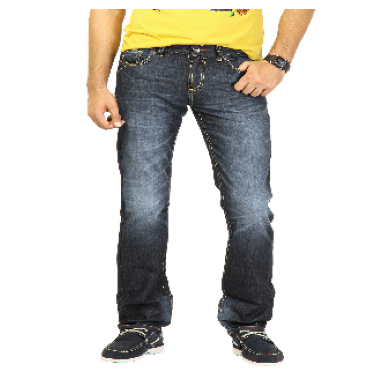

In [27]:
image_path='../dataset/test-images/11330.jpg'
show_image(image_path)

In [28]:
preds = predict(interpreter, prepare_input(image_path))
top_predictions = decode_predictions(preds, class_indices)
print("Top 5 Predictions:")
for class_label, score in top_predictions:
    print(f"{class_label}: {score:.4f}")

Top 5 Predictions:
Jeans: 0.9998
Trousers: 0.0001
Jeggings: 0.0001
Capris: 0.0000
Tshirts: 0.0000


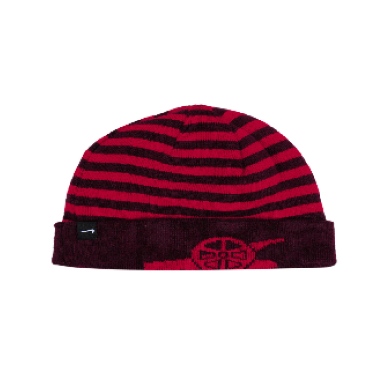

In [29]:
image_path='../dataset/test-images/22633.jpg'
show_image(image_path)

In [30]:
preds = predict(interpreter, prepare_input(image_path))
top_predictions = decode_predictions(preds, class_indices)
print("Top 5 Predictions:")
for class_label, score in top_predictions:
    print(f"{class_label}: {score:.4f}")

Top 5 Predictions:
Caps: 1.0000
Trunk: 0.0000
Backpacks: 0.0000
Skirts: 0.0000
Wallets: 0.0000


## Running predictions for images of articles that the model doesnt recognize correctly

In [31]:
image_path='../dataset/test-images/54558.jpg'

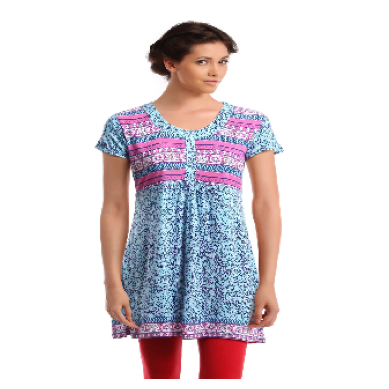

In [32]:
show_image(image_path)

In [33]:
preds = predict(interpreter, prepare_input(image_path))
top_predictions = decode_predictions(preds, class_indices)
print("Top 5 Predictions:")
for class_label, score in top_predictions:
    print(f"{class_label}: {score:.4f}")

Top 5 Predictions:
Kurtas: 0.7537
Tunics: 0.1750
Kurtis: 0.0595
Night suits: 0.0030
Dresses: 0.0018


In [ ]:
#Even when the highest prediction doesnt correspond to "Tunic", that was the expected classification, the model classifies the item
# as "Kurtas" and a kurta is actually a type of tunic (besides that, the second most probable class assigned by the model is "Tunics")

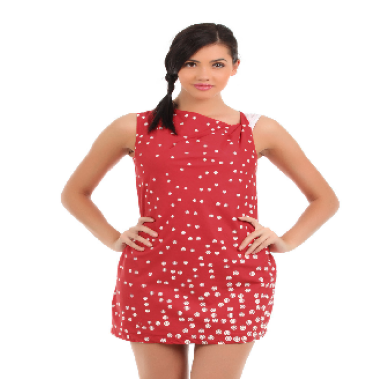

In [34]:
image_path='../dataset/test-images/57199.jpg'
show_image(image_path)

In [35]:
preds = predict(interpreter, prepare_input(image_path))
top_predictions = decode_predictions(preds, class_indices)
print("Top 5 Predictions:")
for class_label, score in top_predictions:
    print(f"{class_label}: {score:.4f}")

Top 5 Predictions:
Dresses: 0.5702
Nightdress: 0.3382
Tunics: 0.0490
Kurtas: 0.0113
Bath Robe: 0.0101


In [ ]:
#This item is classified in the dataset as "Tunics", but it actually looks like a Dress and the model classifies it as such.
#(notice that 'Tunics' is the 4th option, so at least the model recognizes that it somehow looks like a tunic)